In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, classification_report,roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import warnings
import joblib
import json
from datetime import datetime
import os

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create directories for saving models and artifacts
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)


In [3]:
# Load preprocessed data
df = pd.read_csv('./data/thyroid_selected_features.csv')
df.head()

,sex,pregnant,query_hyperthyroid,goitre,psych,TSH_measured,TSH,T3_measured,T3,TT4,...,T4U,FTI,T3_T4_ratio,TSH_T4_product,any_treatment,medical_complexity_score,symptom_query_score,target,target_binary,patient_id
0,0,0,0,0,0,1,0.3,0,1.9,104.0,...,0.96,109.0,0.018269,31.2,0,0,1,-,0,840801013
1,0,0,0,0,0,1,1.6,1,1.9,128.0,...,0.96,109.0,0.014844,204.8,0,0,0,-,0,840801014
2,0,0,1,0,0,0,1.4,0,1.9,104.0,...,0.96,109.0,0.018269,145.6,0,0,1,-,0,840801042
3,0,0,0,0,0,0,1.4,0,1.9,104.0,...,0.96,109.0,0.018269,145.6,0,0,0,-,0,840803046
4,0,0,0,0,0,0,1.4,0,1.9,104.0,...,0.96,109.0,0.018269,145.6,0,0,0,S,1,840803047


In [5]:
# Prepare features and targets
feature_columns = [col for col in df.columns if col not in ['target', 'target_binary', 'patient_id']]
X = df[feature_columns].copy()
y_binary = df['target_binary'].copy()
y_multiclass = df['target'].copy()

print(f"Features shape: {X.shape}")
print(f"Features: {feature_columns}")

Features shape: (9172, 18)
Features: ['sex', 'pregnant', 'query_hyperthyroid', 'goitre', 'psych', 'TSH_measured', 'TSH', 'T3_measured', 'T3', 'TT4', 'T4U_measured', 'T4U', 'FTI', 'T3_T4_ratio', 'TSH_T4_product', 'any_treatment', 'medical_complexity_score', 'symptom_query_score']


## Data Splitting

In [7]:
# Split for binary classification (Stage 1)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
)

# Further split training into train and validation
X_train_bin_final, X_val_bin, y_train_bin_final, y_val_bin = train_test_split(
    X_train_bin, y_train_bin, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_bin
)

print(f"Binary Classification Split:")
print(f"Training: {X_train_bin_final.shape[0]} samples")
print(f"Validation: {X_val_bin.shape[0]} samples")
print(f"Test: {X_test_bin.shape[0]} samples")

Binary Classification Split:
Training: 5869 samples
Validation: 1468 samples
Test: 1835 samples


In [8]:
# Split for multi-class classification (Stage 2) - only sick patients
df_sick = df[df['target_binary'] == 1].copy()

# Filter out rare classes (keep only classes with at least 10 samples)
class_counts = df_sick['target'].value_counts()
valid_classes = class_counts[class_counts >= 10].index.tolist()
df_sick_filtered = df_sick[df_sick['target'].isin(valid_classes)].copy()

X_sick = df_sick_filtered[feature_columns].copy()
y_sick = df_sick_filtered['target'].copy()

print(f"Multi-class Classification (Sick patients only):")
print(f"Total sick patients: {len(df_sick)}")
print(f"After filtering rare classes (< 10 samples): {len(df_sick_filtered)}")
print(f"Number of classes: {len(valid_classes)}")
print(f"Classes: {sorted(valid_classes)}")


Multi-class Classification (Sick patients only):
Total sick patients: 2401
After filtering rare classes (< 10 samples): 2361
Number of classes: 20
Classes: ['A', 'AK', 'B', 'C|I', 'F', 'G', 'GI', 'GK', 'I', 'J', 'K', 'KJ', 'L', 'M', 'MK', 'N', 'O', 'Q', 'R', 'S']


In [9]:
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_sick, y_sick, test_size=0.2, random_state=RANDOM_STATE, stratify=y_sick
)

X_train_multi_final, X_val_multi, y_train_multi_final, y_val_multi = train_test_split(
    X_train_multi, y_train_multi, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_multi
)

print(f"Training: {X_train_multi_final.shape[0]} samples")
print(f"Validation: {X_val_multi.shape[0]} samples")
print(f"Test: {X_test_multi.shape[0]} samples")

Training: 1510 samples
Validation: 378 samples
Test: 473 samples


## Encoding the Data

In [10]:
# Encode multi-class labels for models that require numeric labels
label_encoder = LabelEncoder()
y_train_multi_encoded = label_encoder.fit_transform(y_train_multi_final)
y_val_multi_encoded = label_encoder.transform(y_val_multi)
y_test_multi_encoded = label_encoder.transform(y_test_multi)

# Save label encoder
joblib.dump(label_encoder, './models/label_encoder_multiclass.pkl')
print(f"Label encoder saved (classes: {label_encoder.classes_.tolist()})")

Label encoder saved (classes: ['A', 'AK', 'B', 'C|I', 'F', 'G', 'GI', 'GK', 'I', 'J', 'K', 'KJ', 'L', 'M', 'MK', 'N', 'O', 'Q', 'R', 'S'])


## Feature Scaling

In [11]:
scaler_bin = StandardScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin_final)
X_val_bin_scaled = scaler_bin.transform(X_val_bin)
X_test_bin_scaled = scaler_bin.transform(X_test_bin)

scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi_final)
X_val_multi_scaled = scaler_multi.transform(X_val_multi)
X_test_multi_scaled = scaler_multi.transform(X_test_multi)

# Save scalers
joblib.dump(scaler_bin, './models/scaler_binary.pkl')
joblib.dump(scaler_multi, './models/scaler_multiclass.pkl')

['models/scaler_multiclass.pkl']

## Model Development and Evaluation

In [12]:
# Define models for binary classification
binary_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=10, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', scale_pos_weight=len(y_train_bin_final[y_train_bin_final==0])/len(y_train_bin_final[y_train_bin_final==1])),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE, class_weight='balanced'),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=RANDOM_STATE, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# Define models for multi-class classification
multiclass_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, multi_class='multinomial', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=10, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='mlogloss', objective='multi:softmax'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE, class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

In [13]:
def evaluate_binary_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    """Comprehensive evaluation for binary classification"""
    results = {}

    # Train the model
    print(f"\n  Training {model_name}...")
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Probabilities (for ROC-AUC)
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = y_train_pred
        y_val_proba = y_val_pred
        y_test_proba = y_test_pred

    # Calculate metrics for each set
    for set_name, y_true, y_pred, y_proba in [
        ('train', y_train, y_train_pred, y_train_proba),
        ('val', y_val, y_val_pred, y_val_proba),
        ('test', y_test, y_test_pred, y_test_proba)
    ]:
        results[f'{set_name}_accuracy'] = accuracy_score(y_true, y_pred)
        results[f'{set_name}_precision'] = precision_score(y_true, y_pred, zero_division=0)
        results[f'{set_name}_recall'] = recall_score(y_true, y_pred, zero_division=0)
        results[f'{set_name}_f1'] = f1_score(y_true, y_pred, zero_division=0)
        try:
            results[f'{set_name}_roc_auc'] = roc_auc_score(y_true, y_proba)
        except:
            results[f'{set_name}_roc_auc'] = np.nan

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    results['cv_f1_mean'] = cv_scores.mean()
    results['cv_f1_std'] = cv_scores.std()

    print(f"{model_name} - Test F1: {results['test_f1']:.4f}, Test Accuracy: {results['test_accuracy']:.4f}")

    return model, results

def evaluate_multiclass_model(model, X_train, X_val, X_test, y_train, y_val, y_test,
                             y_train_encoded, y_val_encoded, y_test_encoded, model_name):
    """Comprehensive evaluation for multi-class classification"""
    results = {}

    # Use encoded labels for XGBoost, original labels for others
    if 'XGBoost' in model_name:
        y_train_use = y_train_encoded
        y_val_use = y_val_encoded
        y_test_use = y_test_encoded
    else:
        y_train_use = y_train
        y_val_use = y_val
        y_test_use = y_test

    # Train the model
    print(f"\n  Training {model_name}...")
    model.fit(X_train, y_train_use)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Calculate metrics for each set
    for set_name, y_true, y_pred in [
        ('train', y_train_use, y_train_pred),
        ('val', y_val_use, y_val_pred),
        ('test', y_test_use, y_test_pred)
    ]:
        results[f'{set_name}_accuracy'] = accuracy_score(y_true, y_pred)
        results[f'{set_name}_precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
        results[f'{set_name}_recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
        results[f'{set_name}_f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
        results[f'{set_name}_precision_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        results[f'{set_name}_recall_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        results[f'{set_name}_f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train_use, cv=5, scoring='f1_weighted')
    results['cv_f1_weighted_mean'] = cv_scores.mean()
    results['cv_f1_weighted_std'] = cv_scores.std()

    print(f"{model_name} - Test F1 (weighted): {results['test_f1_weighted']:.4f}, Test Accuracy: {results['test_accuracy']:.4f}")

    return model, results

Binary Classification (Healthy vs With Thyroid Disease)

In [14]:
binary_results = {}
trained_binary_models = {}

for model_name, model in binary_models.items():
    trained_model, results = evaluate_binary_model(
        model,
        X_train_bin_scaled, X_val_bin_scaled, X_test_bin_scaled,
        y_train_bin_final, y_val_bin, y_test_bin,
        model_name
    )
    binary_results[model_name] = results
    trained_binary_models[model_name] = trained_model

# Create results DataFrame
binary_results_df = pd.DataFrame(binary_results).T
binary_results_df = binary_results_df.sort_values('test_f1', ascending=False)

print("BINARY CLASSIFICATION RESULTS")
print(binary_results_df[['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc', 'cv_f1_mean']].round(4))

# Save binary results
binary_results_df.to_csv('results/binary_classification_results.csv')
print("Binary classification results saved to './results/binary_classification_results.csv'")

# Save best binary model
best_binary_model_name = binary_results_df['test_f1'].idxmax()
best_binary_model = trained_binary_models[best_binary_model_name]
joblib.dump(best_binary_model, './models/best_binary_model.pkl')
print(f"Best binary model ({best_binary_model_name}) saved to './models/best_binary_model.pkl'")


  Training Logistic Regression...
Logistic Regression - Test F1: 0.6506, Test Accuracy: 0.7940

  Training Decision Tree...
Decision Tree - Test F1: 0.8829, Test Accuracy: 0.9341

  Training Random Forest...
Random Forest - Test F1: 0.8761, Test Accuracy: 0.9330

  Training XGBoost...
XGBoost - Test F1: 0.8887, Test Accuracy: 0.9384

  Training Gradient Boosting...
Gradient Boosting - Test F1: 0.8926, Test Accuracy: 0.9439

  Training SVM (RBF)...
SVM (RBF) - Test F1: 0.8329, Test Accuracy: 0.9025

  Training SVM (Linear)...
SVM (Linear) - Test F1: 0.6607, Test Accuracy: 0.8142

  Training Naive Bayes...
Naive Bayes - Test F1: 0.7273, Test Accuracy: 0.8643

  Training K-Nearest Neighbors...
K-Nearest Neighbors - Test F1: 0.7835, Test Accuracy: 0.8910
BINARY CLASSIFICATION RESULTS
                     test_accuracy  test_precision  test_recall  test_f1  \
Gradient Boosting           0.9439          0.8935       0.8917   0.8926   
XGBoost                     0.9384          0.8430      

Multi Classification (Type of Thyroid Disease)

In [15]:
multiclass_results = {}
trained_multiclass_models = {}

for model_name, model in multiclass_models.items():
    trained_model, results = evaluate_multiclass_model(
        model,
        X_train_multi_scaled, X_val_multi_scaled, X_test_multi_scaled,
        y_train_multi_final, y_val_multi, y_test_multi,
        y_train_multi_encoded, y_val_multi_encoded, y_test_multi_encoded,
        model_name
    )
    multiclass_results[model_name] = results
    trained_multiclass_models[model_name] = trained_model

# Create results DataFrame
multiclass_results_df = pd.DataFrame(multiclass_results).T
multiclass_results_df = multiclass_results_df.sort_values('test_f1_weighted', ascending=False)

print("MULTI-CLASS CLASSIFICATION RESULTS")
print(multiclass_results_df[['test_accuracy', 'test_precision_weighted', 'test_recall_weighted',
                              'test_f1_weighted', 'test_f1_macro', 'cv_f1_weighted_mean']].round(4))

# Save multi-class results
multiclass_results_df.to_csv('./results/multiclass_classification_results.csv')
print("Multi-class classification results saved to './results/multiclass_classification_results.csv'")

# Save best multi-class model
best_multiclass_model_name = multiclass_results_df['test_f1_weighted'].idxmax()
best_multiclass_model = trained_multiclass_models[best_multiclass_model_name]
joblib.dump(best_multiclass_model, './models/best_multiclass_model.pkl')
print(f"Best multi-class model ({best_multiclass_model_name}) saved to './models/best_multiclass_model.pkl'")


  Training Logistic Regression...
Logistic Regression - Test F1 (weighted): 0.8082, Test Accuracy: 0.7928

  Training Decision Tree...
Decision Tree - Test F1 (weighted): 0.8713, Test Accuracy: 0.8710

  Training Random Forest...
Random Forest - Test F1 (weighted): 0.9099, Test Accuracy: 0.9154

  Training XGBoost...
XGBoost - Test F1 (weighted): 0.8945, Test Accuracy: 0.9006

  Training Gradient Boosting...
Gradient Boosting - Test F1 (weighted): 0.8724, Test Accuracy: 0.8732

  Training SVM (RBF)...
SVM (RBF) - Test F1 (weighted): 0.7847, Test Accuracy: 0.7696

  Training Naive Bayes...
Naive Bayes - Test F1 (weighted): 0.3054, Test Accuracy: 0.3002

  Training K-Nearest Neighbors...
K-Nearest Neighbors - Test F1 (weighted): 0.7684, Test Accuracy: 0.7801
MULTI-CLASS CLASSIFICATION RESULTS
                     test_accuracy  test_precision_weighted  \
Random Forest               0.9154                   0.9090   
XGBoost                     0.9006                   0.8955   
Gradient

✓ Binary classification comparison plot saved
✓ Multi-class classification comparison plot saved
✓ Binary confusion matrix saved
✓ Multi-class confusion matrix saved
✓ ROC curve saved
✓ Cross-validation comparison saved


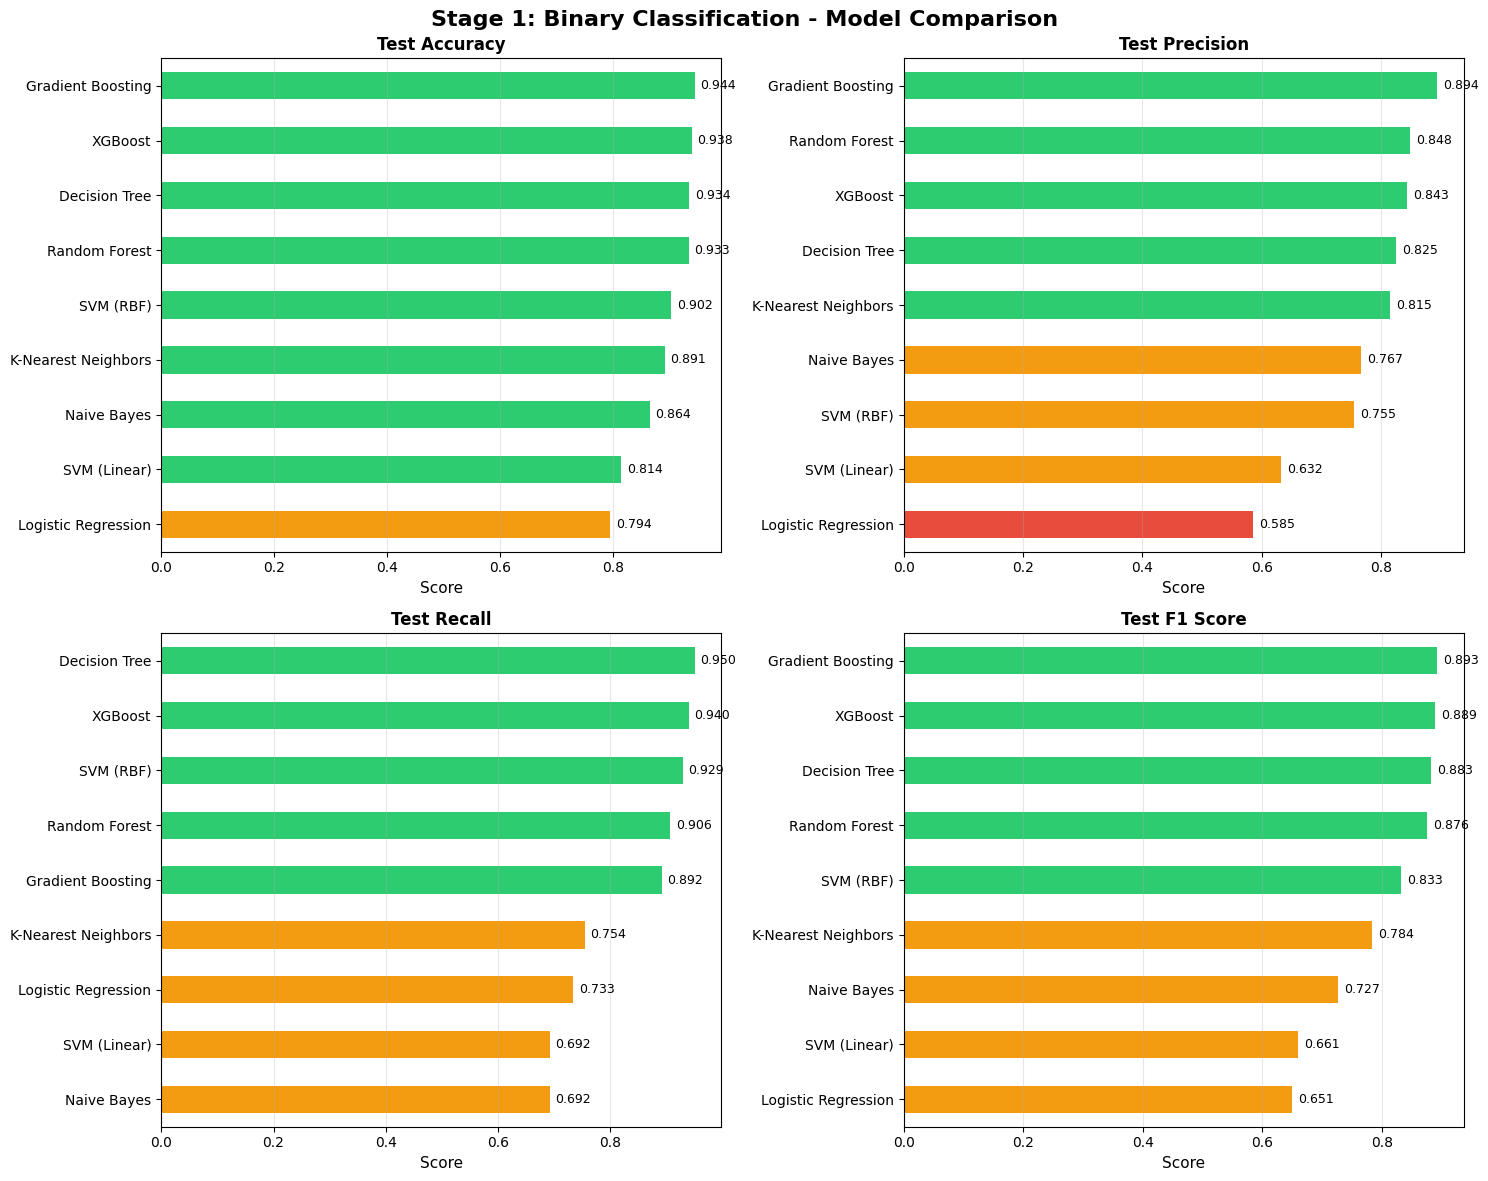

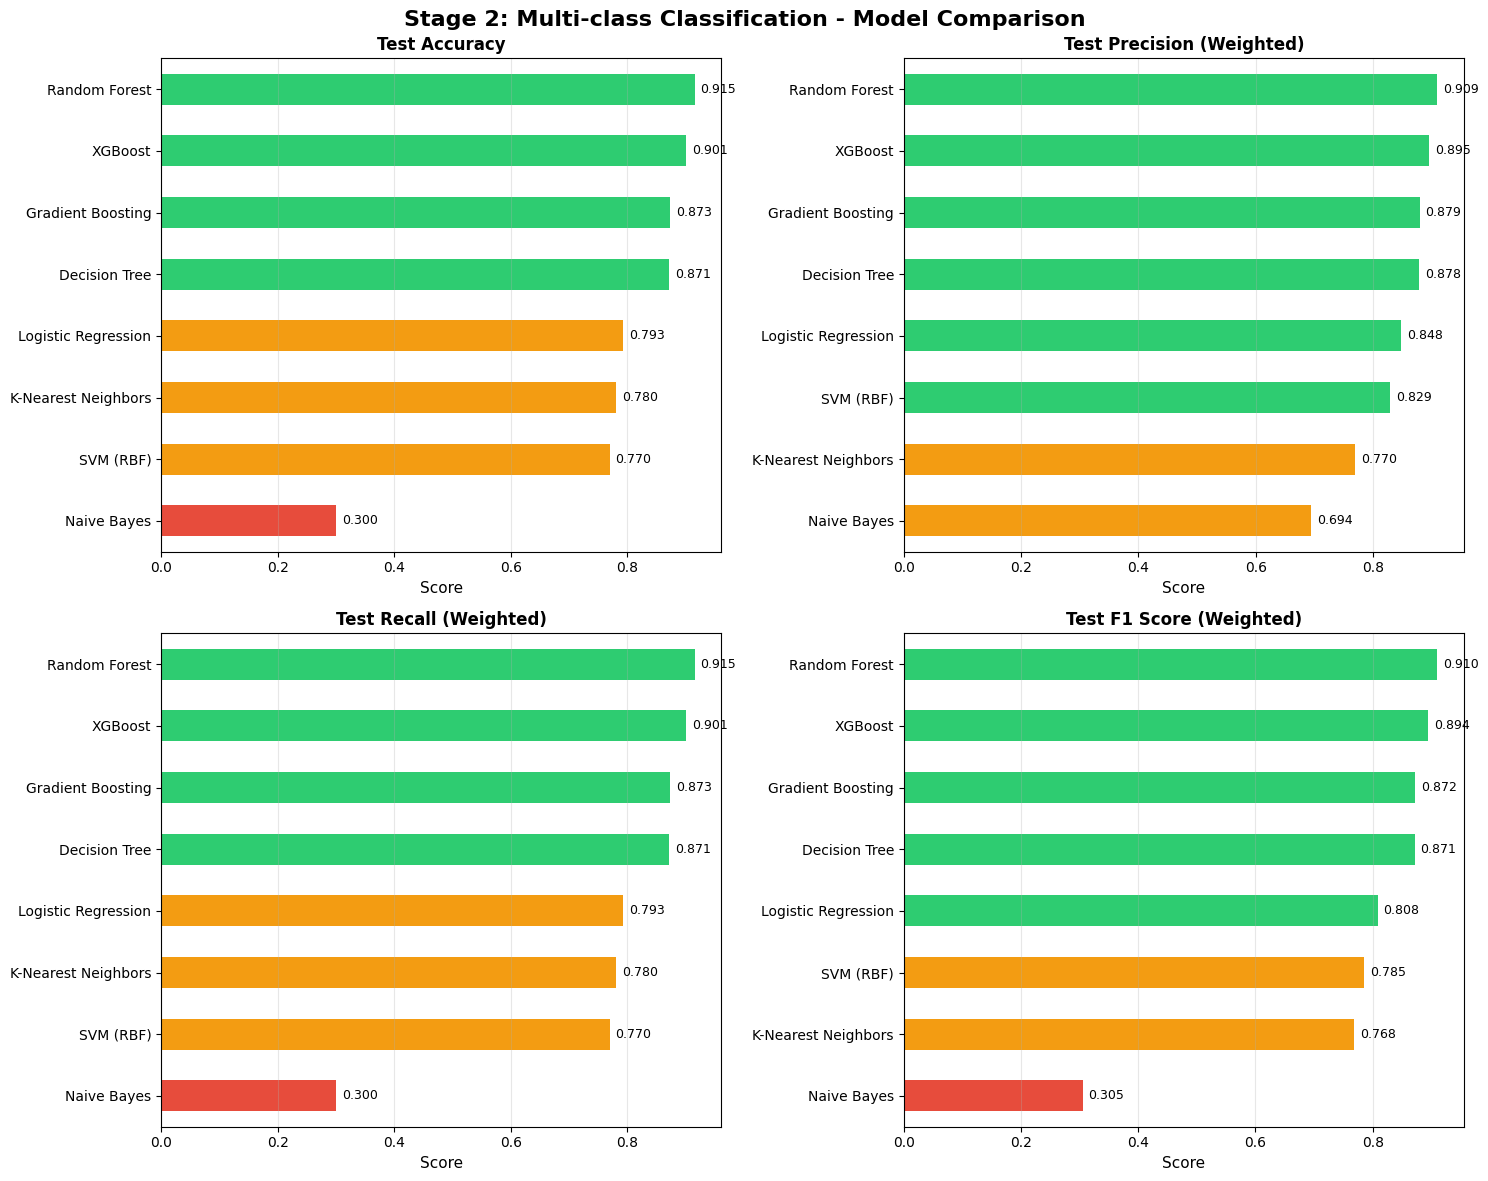

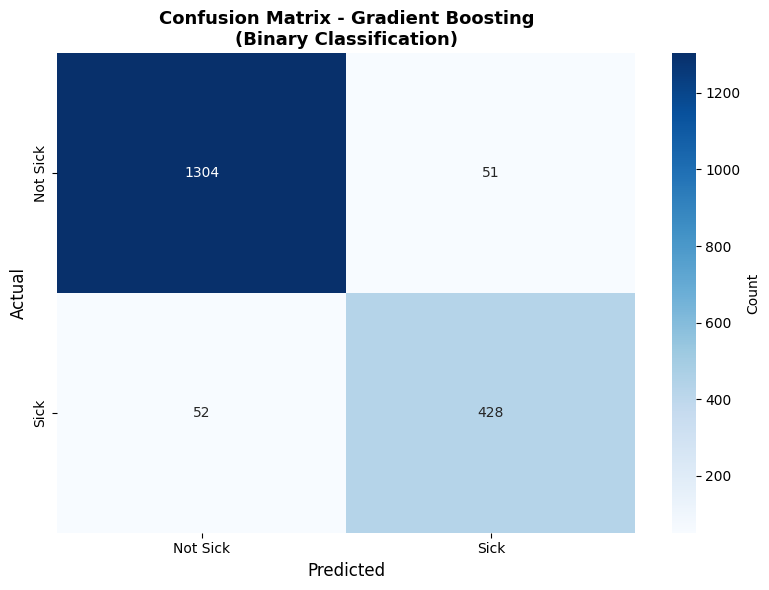

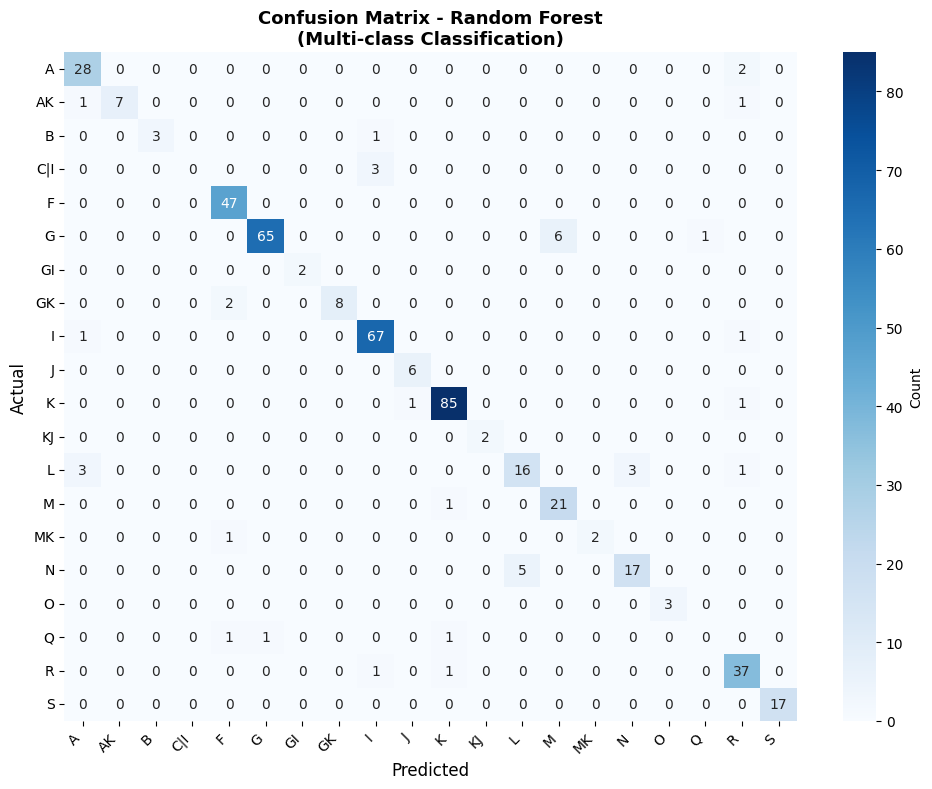

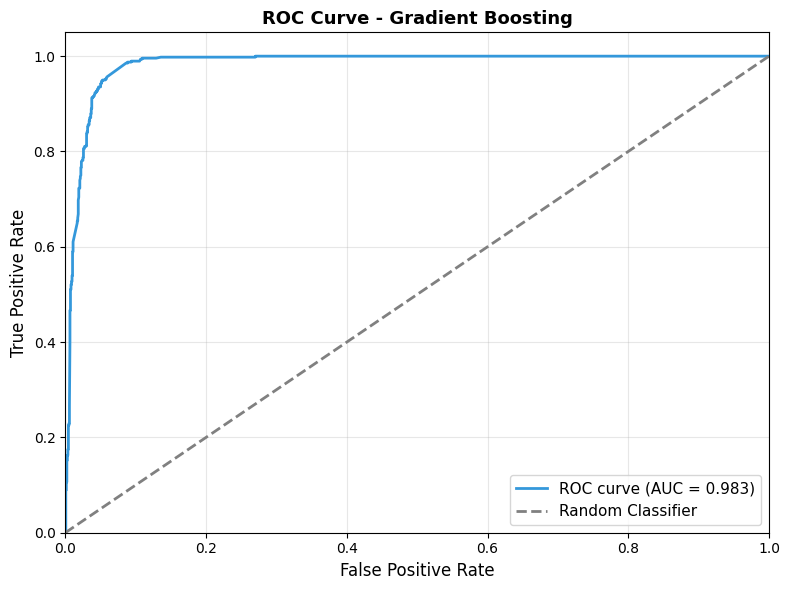

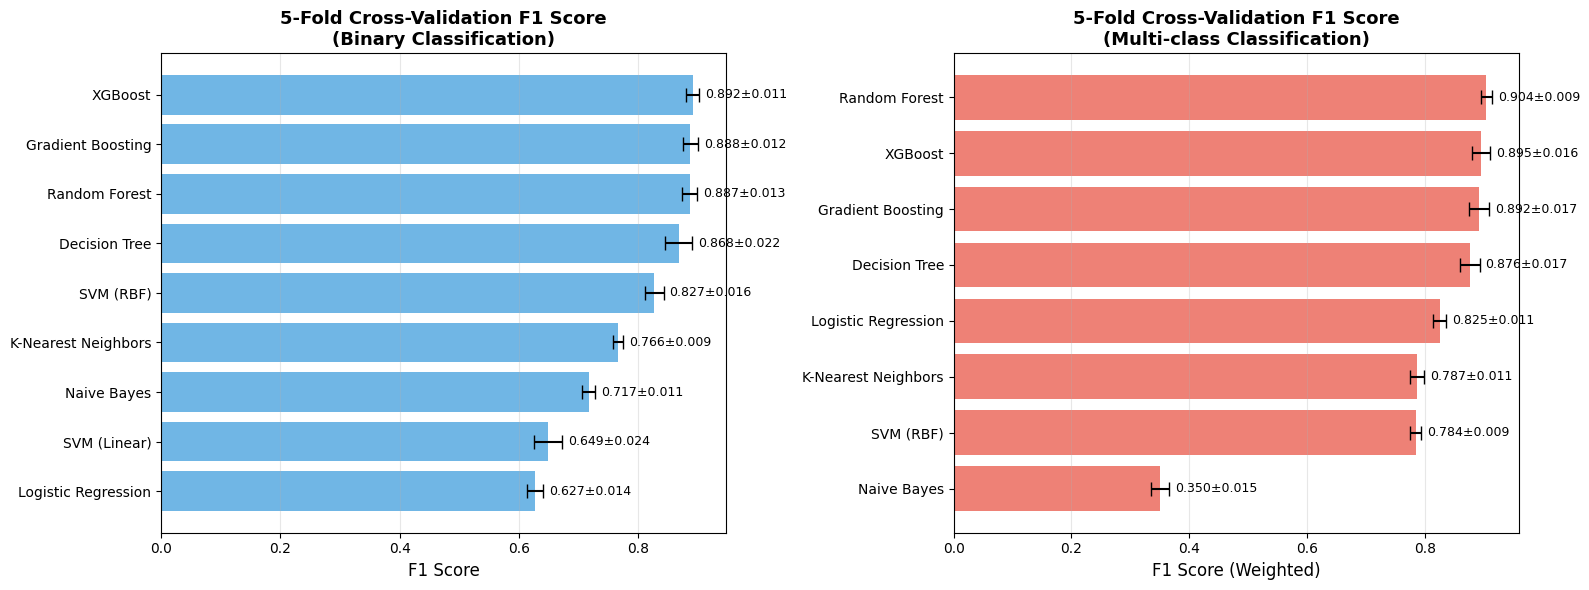

In [16]:
# Figure 1: Binary Classification Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Stage 1: Binary Classification - Model Comparison', fontsize=16, fontweight='bold')

metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
titles = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    data = binary_results_df[metric].sort_values(ascending=True)
    colors = ['#2ecc71' if x > 0.8 else '#f39c12' if x > 0.6 else '#e74c3c' for x in data]
    data.plot(kind='barh', ax=ax, color=colors)
    ax.set_xlabel('Score', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(data):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/binary_classification_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Binary classification comparison plot saved")

# Figure 2: Multi-class Classification Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Stage 2: Multi-class Classification - Model Comparison', fontsize=16, fontweight='bold')

metrics = ['test_accuracy', 'test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted']
titles = ['Test Accuracy', 'Test Precision (Weighted)', 'Test Recall (Weighted)', 'Test F1 Score (Weighted)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    data = multiclass_results_df[metric].sort_values(ascending=True)
    colors = ['#2ecc71' if x > 0.8 else '#f39c12' if x > 0.6 else '#e74c3c' for x in data]
    data.plot(kind='barh', ax=ax, color=colors)
    ax.set_xlabel('Score', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(data):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/multiclass_classification_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Multi-class classification comparison plot saved")

# Figure 3: Confusion Matrix - Best Binary Model
y_pred_bin = best_binary_model.predict(X_test_bin_scaled)
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_binary_model_name}\n(Binary Classification)', fontsize=13, fontweight='bold')
ax.set_xticklabels(['Not Sick', 'Sick'])
ax.set_yticklabels(['Not Sick', 'Sick'])
plt.tight_layout()
plt.savefig('figures/confusion_matrix_binary_best.png', dpi=300, bbox_inches='tight')
print("✓ Binary confusion matrix saved")

# Figure 4: Confusion Matrix - Best Multi-class Model
y_pred_multi = best_multiclass_model.predict(X_test_multi_scaled)
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_multiclass_model_name}\n(Multi-class Classification)',
             fontsize=13, fontweight='bold')
class_labels = sorted(y_test_multi.unique())
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.set_yticklabels(class_labels, rotation=0)
plt.tight_layout()
plt.savefig('figures/confusion_matrix_multiclass_best.png', dpi=300, bbox_inches='tight')
print("✓ Multi-class confusion matrix saved")

# Figure 5: ROC Curve - Best Binary Model
if hasattr(best_binary_model, 'predict_proba'):
    y_pred_proba = best_binary_model.predict_proba(X_test_bin_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(fpr, tpr, color='#3498db', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curve - {best_binary_model_name}', fontsize=13, fontweight='bold')
    ax.legend(loc="lower right", fontsize=11)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('figures/roc_curve_binary_best.png', dpi=300, bbox_inches='tight')
    print("✓ ROC curve saved")

# Figure 6: Cross-validation Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Binary CV scores
cv_data_bin = binary_results_df[['cv_f1_mean', 'cv_f1_std']].sort_values('cv_f1_mean', ascending=True)
ax1.barh(range(len(cv_data_bin)), cv_data_bin['cv_f1_mean'],
         xerr=cv_data_bin['cv_f1_std'], color='#3498db', alpha=0.7, capsize=5)
ax1.set_yticks(range(len(cv_data_bin)))
ax1.set_yticklabels(cv_data_bin.index)
ax1.set_xlabel('F1 Score', fontsize=12)
ax1.set_title('5-Fold Cross-Validation F1 Score\n(Binary Classification)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, (mean, std) in enumerate(zip(cv_data_bin['cv_f1_mean'], cv_data_bin['cv_f1_std'])):
    ax1.text(mean + std + 0.01, i, f'{mean:.3f}±{std:.3f}', va='center', fontsize=9)

# Multi-class CV scores
cv_data_multi = multiclass_results_df[['cv_f1_weighted_mean', 'cv_f1_weighted_std']].sort_values('cv_f1_weighted_mean', ascending=True)
ax2.barh(range(len(cv_data_multi)), cv_data_multi['cv_f1_weighted_mean'],
         xerr=cv_data_multi['cv_f1_weighted_std'], color='#e74c3c', alpha=0.7, capsize=5)
ax2.set_yticks(range(len(cv_data_multi)))
ax2.set_yticklabels(cv_data_multi.index)
ax2.set_xlabel('F1 Score (Weighted)', fontsize=12)
ax2.set_title('5-Fold Cross-Validation F1 Score\n(Multi-class Classification)', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, (mean, std) in enumerate(zip(cv_data_multi['cv_f1_weighted_mean'], cv_data_multi['cv_f1_weighted_std'])):
    ax2.text(mean + std + 0.01, i, f'{mean:.3f}±{std:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/cross_validation_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Cross-validation comparison saved")

## Classification Reports

In [17]:
# Binary classification report
y_pred_bin = best_binary_model.predict(X_test_bin_scaled)
print("Best Binary Model Classification Report")
print(f"Model: {best_binary_model_name}")
print("\n" + classification_report(y_test_bin, y_pred_bin, target_names=['Not Sick', 'Sick']))

# Save to file
with open('./results/binary_classification_report.txt', 'w') as f:
    f.write(f"BINARY CLASSIFICATION REPORT\n")
    f.write(f"Model: {best_binary_model_name}\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*50 + "\n\n")
    f.write(classification_report(y_test_bin, y_pred_bin, target_names=['Not Sick', 'Sick']))

# Multi-class classification report
y_pred_multi = best_multiclass_model.predict(X_test_multi_scaled)
print("Best Multi-class Model Classification Report")
print(f"Model: {best_multiclass_model_name}")
print("\n" + classification_report(y_test_multi, y_pred_multi))

# Save to file
with open('./results/multiclass_classification_report.txt', 'w') as f:
    f.write(f"MULTI-CLASS CLASSIFICATION REPORT\n")
    f.write(f"Model: {best_multiclass_model_name}\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*50 + "\n\n")
    f.write(classification_report(y_test_multi, y_pred_multi))

Best Binary Model Classification Report
Model: Gradient Boosting

              precision    recall  f1-score   support

    Not Sick       0.96      0.96      0.96      1355
        Sick       0.89      0.89      0.89       480

    accuracy                           0.94      1835
   macro avg       0.93      0.93      0.93      1835
weighted avg       0.94      0.94      0.94      1835

Best Multi-class Model Classification Report
Model: Random Forest

              precision    recall  f1-score   support

           A       0.85      0.93      0.89        30
          AK       1.00      0.78      0.88         9
           B       1.00      0.75      0.86         4
         C|I       0.00      0.00      0.00         3
           F       0.92      1.00      0.96        47
           G       0.98      0.90      0.94        72
          GI       1.00      1.00      1.00         2
          GK       1.00      0.80      0.89        10
           I       0.93      0.97      0.95        69

## Save configuration and metadata

In [18]:
config = {
    'random_state': RANDOM_STATE,
    'test_size': 0.2,
    'validation_size': 0.2,
    'cv_folds': 5,
    'feature_columns': feature_columns,
    'binary_models': list(binary_models.keys()),
    'multiclass_models': list(multiclass_models.keys()),
    'best_binary_model': best_binary_model_name,
    'best_multiclass_model': best_multiclass_model_name,
    'binary_test_f1': float(binary_results_df.loc[best_binary_model_name, 'test_f1']),
    'multiclass_test_f1_weighted': float(multiclass_results_df.loc[best_multiclass_model_name, 'test_f1_weighted']),
    'dataset_shape': df.shape,
    'binary_class_distribution': df['target_binary'].value_counts().to_dict(),
    'multiclass_class_distribution': df['target'].value_counts().to_dict(),
    'execution_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('./models/config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("Configuration saved to './models/config.json'")

Configuration saved to './models/config.json'
